In [103]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout, GRU
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
from nltk.corpus import PlaintextCorpusReader

%matplotlib inline

In [104]:
#Character Level Reading


path = 'nietzsche.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

myText = PlaintextCorpusReader('./','nietzsche.txt')
avg_word_len = len(myText.words('nietzsche.txt'))/len(myText.sents('nietzsche.txt'))
print(avg_word_len)

corpus length: 600901
35.34664679582713


In [105]:
#Creating mappings(Dictionaries) for char->index , index->char

chars = sorted(list(set(text)))
char_indices = dict((c,i) for i,c in enumerate(chars))
indices_char = dict((i,c) for i,c in enumerate(chars))
print(len(chars))
#char_indices

59


In [126]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])

In [127]:
example_index = 10
print('Number of Training Examples: ',len(next_chars))
print('Training Sample: ',sentences[example_index],'\n','Predict: ',next_chars[example_index])

Number of Training Examples:  200287
Training Sample:   is a woman--what then? is there not gro 
 Predict:  u


In [88]:
#Creating One hot Encodings

creator = np.eye(len(chars),dtype= np.bool)
x = np.zeros((len(sentences),SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences),len(chars)), dtype=bool)

for i in range(0,len(sentences)):
    for j in range(0,SEQUENCE_LENGTH):
        x[i][j] = creator[char_indices[sentences[i][j]]]
        
    y[i] = creator[char_indices[next_chars[i]]]

In [89]:
print('Shape of X: ',x.shape)
print('Shape of Y: ',y.shape)

print('Example of X: ',x[0])
print('Corresponding Y: ',y[0])

Shape of X:  (200288, 38, 59)
Shape of Y:  (200288, 59)
Example of X:  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False  True False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Corresponding Y:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False]


In [90]:
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape = (SEQUENCE_LENGTH,len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [91]:
optimizer = RMSprop(lr = 0.01)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

history = model.fit(x,y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 190273 samples, validate on 10015 samples
Epoch 1/20
190273/190273 [==============================] - 158s 833us/step - loss: 1.9701 - acc: 0.4230 - val_loss: 1.7095 - val_acc: 0.4867
Epoch 2/20
190273/190273 [==============================] - 154s 808us/step - loss: 1.7298 - acc: 0.4869 - val_loss: 1.6684 - val_acc: 0.5017
Epoch 3/20
190273/190273 [==============================] - 156s 822us/step - loss: 2.4888 - acc: 0.2985 - val_loss: 2.1216 - val_acc: 0.3775
Epoch 4/20
190273/190273 [==============================] - 157s 827us/step - loss: 1.9522 - acc: 0.4280 - val_loss: 1.9828 - val_acc: 0.4238
Epoch 5/20
190273/190273 [==============================] - 157s 827us/step - loss: 2.2830 - acc: 0.3434 - val_loss: 2.3722 - val_acc: 0.3096
Epoch 6/20
190273/190273 [==============================] - 158s 833us/step - loss: 2.8389 - acc: 0.2087 - val_loss: 2.8409 - val_acc: 0.2024
Epoch 7/20
190273/190273 [==============================] - 159s 835us/step - loss: 3.0133 - acc:

In [114]:
#Saving the model
#File save format: (KP)_(CORPUS)_(SEQUENCE_LENGTH)_(STEP)_(EPOCHS).h5
filename = 'KP_nietzsche_40_3_20_rms'



In [ ]:
#CAREFUL---SAVING MODEL---CAREFUL

model.save(filename+'.h5')
pickle.dump(history, open(filename+'.p', 'wb'))

In [116]:
#loading model

model = load_model(filename+'.h5')
history = pickle.load(open(filename+'.p', 'rb'))

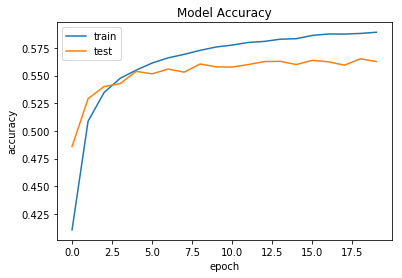

In [117]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')

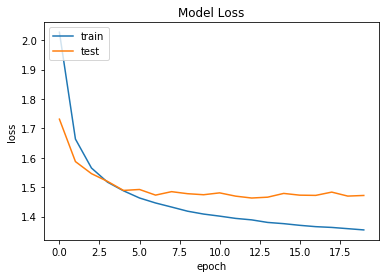

In [118]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [119]:

def prepare_input(text):
    sample_shape = (1,SEQUENCE_LENGTH,len(chars))
    sample_sentence = np.zeros((1, SEQUENCE_LENGTH, len(chars)), dtype=bool)

    for i in range(0,len(text)):
        sample_sentence[0][i] = creator[char_indices[text[i]]]
    
    
    sample_sentence.reshape(sample_shape)
    
    return sample_sentence
'''
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x
'''

'\ndef prepare_input(text):\n    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))\n    for t, char in enumerate(text):\n        x[0, t, char_indices[char]] = 1.\n        \n    return x\n'

In [120]:
one_hot_input = prepare_input('This is an example.'.lower())

index = 2 
#Index in the above sentence

#Verifying
indices_char[np.argmax(one_hot_input[0][index])]

'i'

In [121]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [122]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=3)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [123]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [124]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [128]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'all ', 'such ', 'constance, ', 'man ']

that which does not kill us makes us str
['uggless, ', 'ong ', 'ict ', 'ength ', 'ange ']

i'm not upset that you lied to me, i'm u
['niversal ', 'ltimates ', 'sual ', 'tteral ', 'pon ']

and those who were seen dancing were tho
['se ', 'usand ', 'rough ', 'le ', 'on ']

it is hard enough to remember my opinion
[' of ', ', ', '. ', 's ', '\nand ']

